# Introduction

In this notebook we use Google's Tensorflow library to classify the employee salary into different groups of range.


## Importing Libraries

In [641]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

from sklearn import preprocessing

import tensorflow as tf

from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.models import Model

from scipy import stats


## The data

### Reading the data

Reading the dataset into a Pandas Dataframe Object

In [642]:
data = pd.read_csv("data.csv")
data.head()

,age,work-class,work-fnl,education,education-num,marital-status,position,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Cleaning the data

#### Droping the unnecessary columns

The column 'education-num' is a label-encoded version of the column 'education' with ordinality taken into account, which means that the column 'education' is not needed.

In [643]:
data = data.drop('education', axis=1)
data.head()

,age,work-class,work-fnl,education-num,marital-status,position,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Handling Null Values

There's no null values in the dataset, however there are "?" values which needs to be handled.

In [644]:
data.isna().sum().max()

0

We first need to remove trailing and leading spaces from column values.

In [645]:
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

Then we drop rows containing "?".

In [646]:
data = data[~(data.T == '?').any()]

#### Handling Duplicate Rows

In [647]:
data = data.drop_duplicates()
data.shape

(21108, 14)

#### Handling Categorical values

The columns `work-class`, `marital-status`, `position`, `relationship`, `race`, `sex`, `native-country` and `salary` are categorical. We need to convert them to numeric values.

Since most categorical columns have less than 10 unique values, we can use one hot encoding in favor of label encoding to avoid any bias the model might have with nominal values.


In [648]:
data = pd.get_dummies(data, columns=['position'], prefix='position')
data = pd.get_dummies(data, columns=['native-country'], prefix='country')
data = pd.get_dummies(data, columns=['work-class'], prefix='work')
data = pd.get_dummies(data, columns=['marital-status'], prefix='marital')
data = pd.get_dummies(data, columns=['relationship'], prefix='relationship')
data = pd.get_dummies(data, columns=['race'], prefix='race')
data = pd.get_dummies(data, columns=['sex'], prefix='sex')

data.insert(63, 'work_Never-worked', 0)

position and native-country have more than 10 unique values, so we use label encoding for them.

In [649]:
le = preprocessing.LabelEncoder()

# data['salary'] = le.fit_transform(data.salary.values)
# data['position'] = le.fit_transform(data.position.values)
# data['native-country'] = le.fit_transform(data['native-country'].values)
# data['work-class'] = le.fit_transform(data['work-class'].values)
# data['marital-status'] = le.fit_transform(data['marital-status'].values)
# data['relationship'] = le.fit_transform(data['relationship'].values)
# data['race'] = le.fit_transform(data['race'].values)
# data['sex'] = le.fit_transform(data['sex'].values)

data.replace(['<=50K', '>50K'],
             [0, 1], inplace=True)
data.head()

,age,work-fnl,education-num,capital-gain,capital-loss,hours-per-week,salary,position_Adm-clerical,position_Armed-Forces,position_Craft-repair,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [650]:
data.head()

,age,work-fnl,education-num,capital-gain,capital-loss,hours-per-week,salary,position_Adm-clerical,position_Armed-Forces,position_Craft-repair,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


#### Handling Outliers

Remove outliers that have z score higher than 3 or lower than -3 

In [651]:
data.shape

(21108, 90)

In [652]:
# data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

In [653]:
data.shape

(21108, 90)

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. We will use the test set in the final evaluation of the model.

In [654]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)


In [655]:
train_dataset.shape

(16886, 90)

### Split features from labels

Separate target value —the salary, also called the label— from the features. This label is the value that we will train the model to classify.

In [656]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('salary')
test_labels = test_features.pop('salary')


In [657]:
train_features.shape

(16886, 89)

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [658]:
train_dataset[['capital-gain', 'capital-loss', 'work-fnl', 'age']].describe().transpose()[['mean', 'std']]

,mean,std
capital-gain,1033.677070,7221.840154
capital-loss,86.143077,399.286854
work-fnl,189538.746772,104868.588814
age,38.500059,13.143087


It is good practice to normalize features that have different ranges.

If we skip normalizing the features, the model will still converge (ie: reach the optimum loss), However, normalization makes training much more stable.

### The Normalization layer

The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into the model.

The first step is to create the layer:

In [659]:
normalizer = tf.keras.layers.Normalization(axis=-1)


Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:


In [660]:
normalizer.adapt(np.array(train_features))

When the layer is called, it returns the input data, with each feature independently normalized:

In [661]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


First example: [[    27 108431     10      0      0     40      0      0      1      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      1      0
       0      0      0      0      1      0      0      0      0      0
       0      0      0      1      0      0      0      1      0      0
       0      0      0      0      1      0      0      0      1]]

Normalized: [[-0.88 -0.77 -0.05 -0.14 -0.22 -0.08 -0.38 -0.02  2.56 -0.38 -0.18 -0.21
  -0.26 -0.34 -0.07 -0.39 -0.15 -0.37 -0.18 -0.23 -0.02 -0.06 -0.04 -0.04
  -0.06 -0.05 -0.03 -0.06 -0.06 -0.03 -0.07 -0.03 -0.05 -0.04 -0.01 -0.02
  -0.02 -0.02 -0.06 -0.04 -0.03 -0.05 -0.05 -0.04 -0.02 -0.14 -0.03 -0.02
  -0.03 -0.08 -0.05 -0.04 -0.06 -

## Classification

### Building the Neural Network Model

We first declare the layers of the neural network and their activation functions.


In [662]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])


We then config the model with losses and metrics that we want using `model.compile()`

In [663]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


We then trains the model on the training data for a fixed number of epochs (iterations).

In [664]:
r = model.fit(train_features, train_labels, validation_data=(test_features, test_labels), epochs=50)


Epoch 1/50
528/528 [==============================] - 2s 4ms/step - loss: 0.5681 - accuracy: 0.7553 - val_loss: 0.5517 - val_accuracy: 0.7456
Epoch 2/50
528/528 [==============================] - 2s 3ms/step - loss: 0.5076 - accuracy: 0.7580 - val_loss: 0.4940 - val_accuracy: 0.7698
Epoch 3/50
528/528 [==============================] - 2s 3ms/step - loss: 0.4541 - accuracy: 0.7901 - val_loss: 0.4486 - val_accuracy: 0.7958
Epoch 4/50
528/528 [==============================] - 2s 3ms/step - loss: 0.4195 - accuracy: 0.8116 - val_loss: 0.4238 - val_accuracy: 0.8119
Epoch 5/50
528/528 [==============================] - 2s 3ms/step - loss: 0.3993 - accuracy: 0.8212 - val_loss: 0.4098 - val_accuracy: 0.8155
Epoch 6/50
528/528 [==============================] - 2s 4ms/step - loss: 0.3860 - accuracy: 0.8258 - val_loss: 0.3997 - val_accuracy: 0.8164
Epoch 7/50
528/528 [==============================] - 2s 4ms/step - loss: 0.3762 - accuracy: 0.8283 - val_loss: 0.3924 - val_accuracy: 0.8209
Epoch 

In [665]:
test = pd.read_csv('test.csv')
test = test.drop('education', axis=1)
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test = test.replace('?', np.nan)

test = pd.get_dummies(test, columns=['position'], prefix='position')
test = pd.get_dummies(test, columns=['native-country'], prefix='country')
test = pd.get_dummies(test, columns=['work-class'], prefix='work')
test = pd.get_dummies(test, columns=['marital-status'], prefix='marital')
test = pd.get_dummies(test, columns=['relationship'], prefix='relationship')
test = pd.get_dummies(test, columns=['race'], prefix='race')
test = pd.get_dummies(test, columns=['sex'], prefix='sex')

test.insert(34, 'country_Holand-Netherlands', 0)

print(test.columns)

Index(['age', 'work-fnl', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'position_Adm-clerical', 'position_Armed-Forces',
       'position_Craft-repair', 'position_Exec-managerial',
       'position_Farming-fishing', 'position_Handlers-cleaners',
       'position_Machine-op-inspct', 'position_Other-service',
       'position_Priv-house-serv', 'position_Prof-specialty',
       'position_Protective-serv', 'position_Sales', 'position_Tech-support',
       'position_Transport-moving', 'country_Cambodia', 'country_Canada',
       'country_China', 'country_Columbia', 'country_Cuba',
       'country_Dominican-Republic', 'country_Ecuador', 'country_El-Salvador',
       'country_England', 'country_France', 'country_Germany',
       'country_Greece', 'country_Guatemala', 'country_Haiti',
       'country_Holand-Netherlands', 'country_Honduras', 'country_Hong',
       'country_Hungary', 'country_India', 'country_Iran', 'country_Ireland',
       'country_Italy', 'country

In [677]:
predictions = model.predict(test)

306/306 [==============================] - 0s 2ms/step


In [678]:
predictions = np.argmax(predictions, axis=1)

In [679]:
submission = pd.DataFrame({'index': test.index, 'salary': predictions})

submission['salary'].replace([0, 1], ['<=50K', '>50K'], inplace=True)

submission.to_csv('submission.csv', index=False)


In [680]:
submission

,index,salary
0,0,<=50K
1,1,<=50K
2,2,<=50K
3,3,<=50K
4,4,<=50K
...,...,...
9764,9764,<=50K
9765,9765,<=50K
9766,9766,<=50K
9767,9767,<=50K


## Model Evaluation

`model.fit` returns a history object which contains the loss and accuracy of the model at each epoch. So now we can use this object to plot accuracy across time so as to get a better understanding of the model's performance.


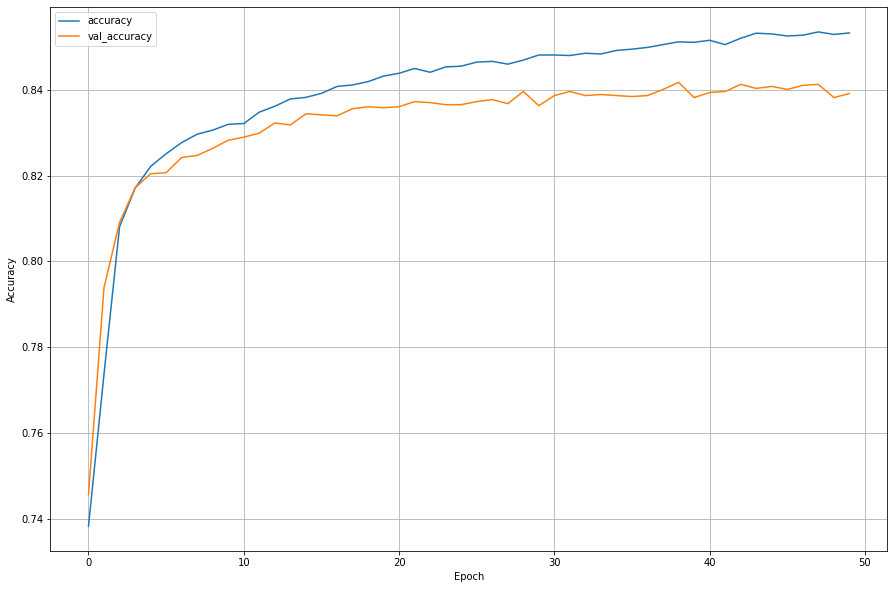

In [430]:
def plot_loss(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_loss(r)

## Make predictions

With the model trained, we now use it to make predictions about the type of the tumor. We attach a softmax layer to convert the model's output to probabilities, which are easier to interpret.

In [166]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])


We let the model predict the clarity of the test set:

In [167]:
predictions = probability_model.predict(test_features)


66/66 [==============================] - 0s 1ms/step


We take a look at the first prediction:

In [168]:
predictions[0]


array([1., 0.], dtype=float32)

The prediction is an array of 2 numbers. They represent the model's "confidence" that the tumor type corresponds to each of the 2 different types.

In [169]:
np.argmax(predictions[0])


0

## Review Performance

To get an overview of the model's performance, we print the confusion matrix of the predicted labels. This shows us how many labels did the model classify correctly and how many did he miss.

In [171]:
predicted = np.argmax(predictions, axis=1)
predicted.shape

confusion_matrix = pd.crosstab(test_labels, predicted, rownames=[
                               'Actual'], colnames=['Predicted'])
print(confusion_matrix)


Predicted     0    1
Actual              
0          1468  163
1           182  284


Now let's visualise the confusion matrix:

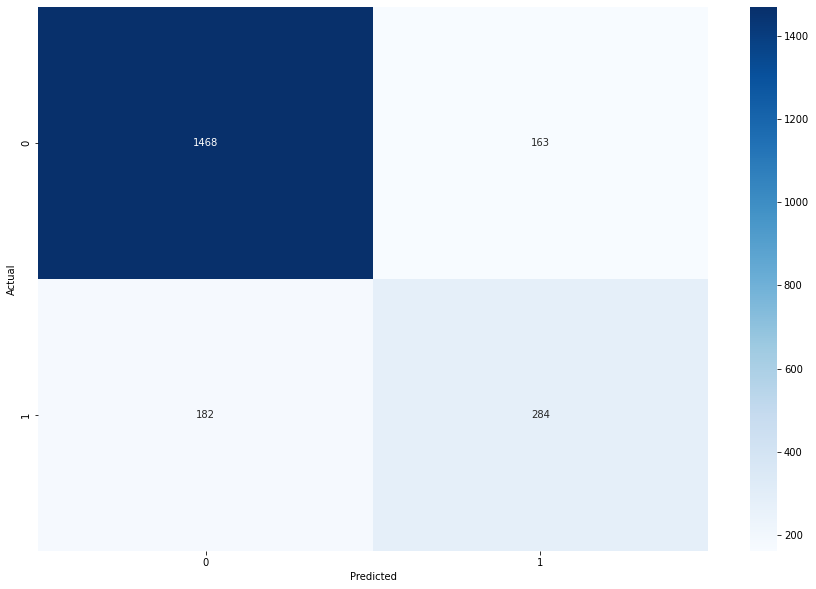

In [172]:
confusion_matrix = pd.crosstab(test_labels, predicted, rownames=[
                               'Actual'], colnames=['Predicted'])

plt.figure(figsize=(15, 10))
plt.ticklabel_format(style='plain')
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()
